## Language Detection using MFCC Features
This program implements MFCC feature extraction (Task A) and language classification (Task B) 
for 10 Indian languages. It includes visualization of MFCC spectrograms, statistical analysis,
and a neural network classifier with performance evaluation.

### Imports and Configuration

In [1]:
import os
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Device configuration

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Audio Processing Parameters

In [3]:
target_sample_rate = 16000
n_mfcc = 20
valid_exts = ('.wav', '.mp3', '.flac')  # Define valid extensions based on your dataset

### MFCC transformation configuration

In [4]:
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=target_sample_rate,
    n_mfcc=n_mfcc,  
    melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40}
).to(device)


### Feature Extraction Function

In [5]:
def extract_mfcc(file_path, sample_rate=16000):
    waveform, sr = torchaudio.load(file_path)  # Load audio
    waveform = waveform.to(device)  # Move to GPU

    if sr != sample_rate:  # Resample if needed
        resampler = T.Resample(sr, sample_rate).to(device)
        waveform = resampler(waveform)

    mfcc = mfcc_transform(waveform)  # (channels, n_mfcc, time)

    return mfcc[0].cpu()  # Select first channel & move to CPU


In [6]:
path = "/kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset"

# Get subfolders (languages)
languages = [f.name for f in os.scandir(path) if f.is_dir()]
languages

['Punjabi',
 'Tamil',
 'Hindi',
 'Bengali',
 'Telugu',
 'Kannada',
 'Gujarati',
 'Urdu',
 'Marathi',
 'Malayalam']

### Visualization Function

In [7]:
def plot_mfcc(languages: list):
    plt.figure(figsize=(20, 15))  # Larger figure for better spacing


    for i, lang in enumerate(languages):
        lang_path = os.path.join(path, lang)
    
        # Get the first valid audio file
        file_name = next((f for f in os.listdir(lang_path) if f.endswith(valid_exts)), None)

        if not file_name:
            print(f"No audio file found for {lang}, skipping...")
            continue

        file_path = os.path.join(lang_path, file_name)
        print(f"Processing {file_path}...")  # Debugging output
    
        mfcc = extract_mfcc(file_path)
    
        plt.subplot(3, 4, i + 1)  # 3x4 layout
        plt.imshow(mfcc.numpy(), aspect="auto", origin="lower", cmap="viridis")
        plt.title(lang, fontsize=16)  # Bigger titles
        plt.xlabel("Time", fontsize=14)
        plt.ylabel("MFCC Coefficients", fontsize=14)

    # Adjust spacing for a cleaner look
    plt.subplots_adjust(hspace=0.5, wspace=0.4)  
    plt.show()
    

Processing /kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset/Punjabi/23694.mp3...
Processing /kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset/Tamil/23694.mp3...
Processing /kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset/Hindi/23694.mp3...
Processing /kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset/Bengali/23694.mp3...
Processing /kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset/Telugu/23694.mp3...
Processing /kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset/Kannada/23694.mp3...
Processing /kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset/Gujarati/23694.mp3...
Processing /kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset/Urdu/23694.mp3...
Processing /kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset/Marathi/23694.mp3...

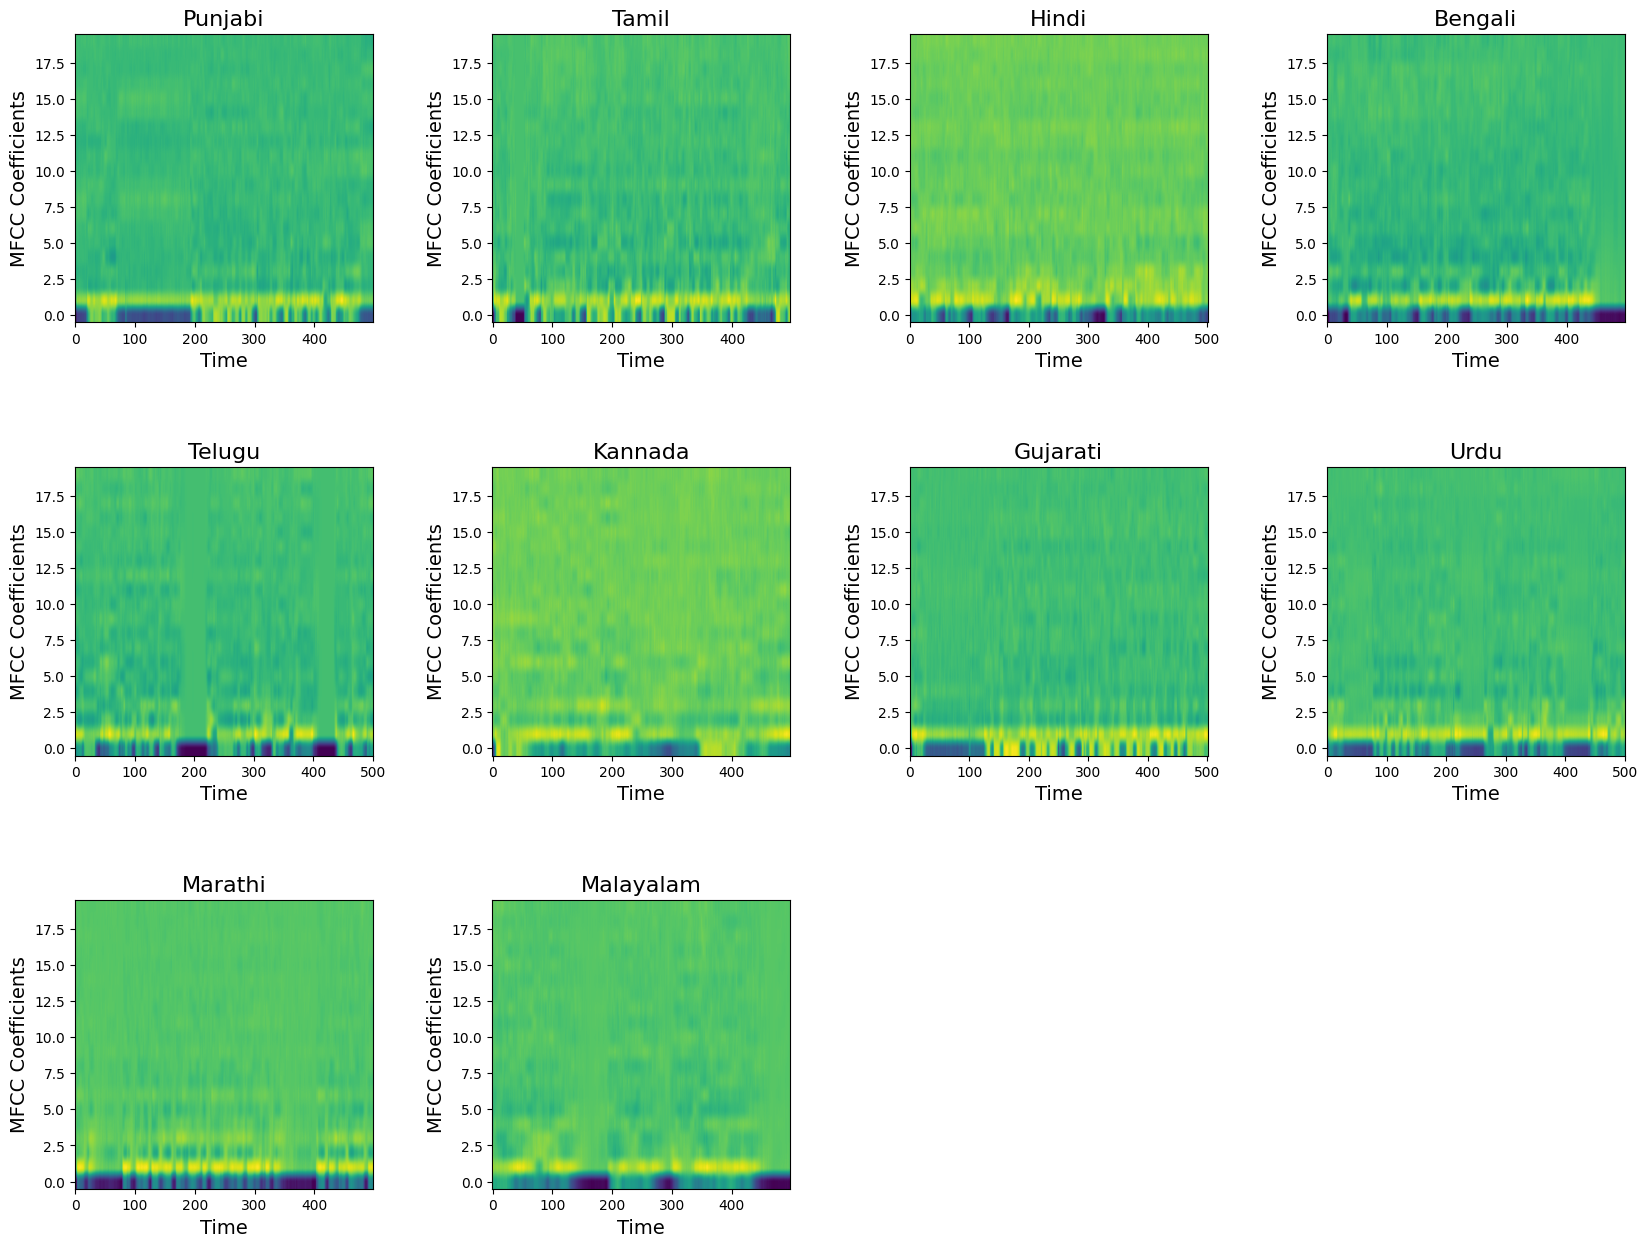

In [8]:
plot_mfcc(languages)

### Statistical Analysis

In [16]:
language_mfcc_stats = {}

for language in languages:
    folder_path = os.path.join(path, language)
    audio_list = [fname for fname in os.listdir(folder_path) if fname.endswith(".mp3")]
    mfcc_means = []
    
    for fname in audio_list[:100]:
        audio_path = os.path.join(folder_path, fname)
        try:
            mfcc_data = extract_mfcc(audio_path)
            mean_coeffs = np.mean(mfcc_data.numpy(), axis=1)
            mfcc_means.append(mean_coeffs)
        except Exception as error:
            print(f"Error with file {audio_path}: {error}")
    
    if mfcc_means:
        mfcc_means = np.array(mfcc_means)
        language_mfcc_stats[language] = {
            "Average": mfcc_means.mean(axis=0),
            "Var": mfcc_means.var(axis=0)
        }

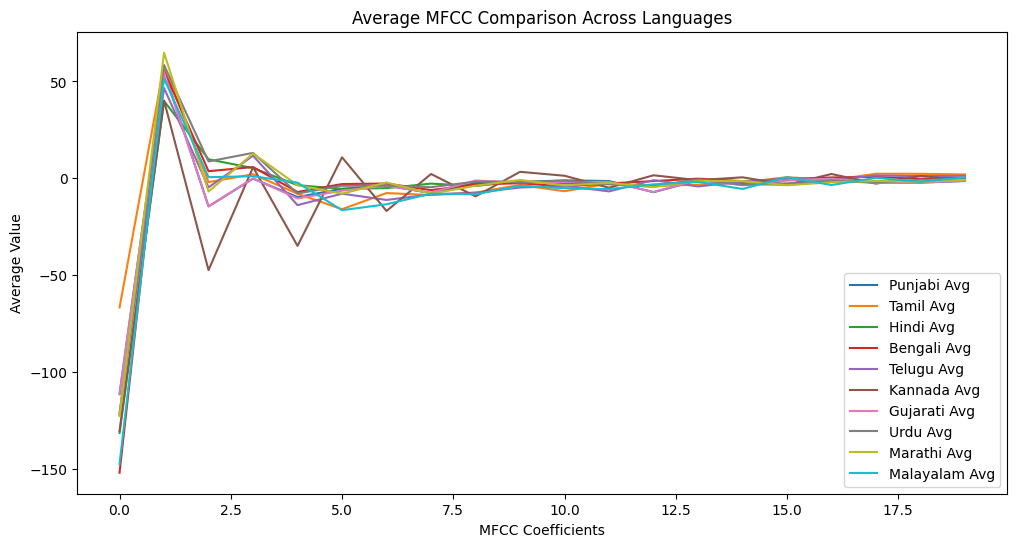

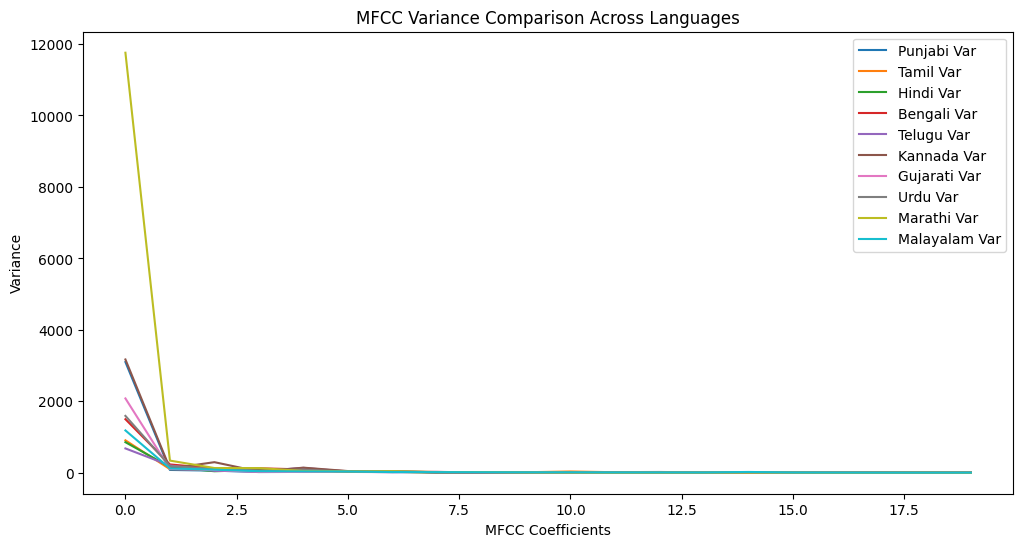

In [17]:

plt.figure(figsize=(12, 6))
for lang, stats in language_mfcc_stats.items():
    plt.plot(stats["Average"], label=f"{lang} Avg")
plt.title("Average MFCC Comparison Across Languages")
plt.xlabel("MFCC Coefficients")
plt.ylabel("Average Value")
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
for lang, stats in language_mfcc_stats.items():
    plt.plot(stats["Var"], label=f"{lang} Var")
plt.title("MFCC Variance Comparison Across Languages")
plt.xlabel("MFCC Coefficients")
plt.ylabel("Variance")
plt.legend()
plt.show()

# TASK B 

In [172]:
features = []
labels = []
label_to_idx = {lang: idx for idx, lang in enumerate(languages)}

In [193]:
label_to_idx

{'Punjabi': 0,
 'Tamil': 1,
 'Hindi': 2,
 'Bengali': 3,
 'Telugu': 4,
 'Kannada': 5,
 'Gujarati': 6,
 'Urdu': 7,
 'Marathi': 8,
 'Malayalam': 9}

### Data Preparation

In [ ]:
print("Extracting MFCC features from audio files...")
for lang in languages:
    lang_path = os.path.join(path, lang)
    files = [f for f in os.listdir(lang_path) if f.endswith(valid_exts)]
    if not files:
        print(f"No valid audio files found for {lang}, skipping...")
        continue
    
    for file_name in files:
        file_path = os.path.join(lang_path, file_name)
        try:
            mfcc = extract_mfcc(file_path)  
            
            mfcc_mean = mfcc.mean(dim=1)  
            features.append(mfcc_mean.numpy())
            labels.append(label_to_idx[lang])
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

In [174]:
features = np.array(features)
labels = np.array(labels)
print(f"Extracted features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")

Extracted features shape: (256824, 20)
Labels shape: (256824,)


In [177]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42, stratify=labels)

### Dataset Class

In [178]:
class MFCCDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = MFCCDataset(X_train, y_train)
test_dataset = MFCCDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Model Definition

In [179]:
class LanguageClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(LanguageClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)



In [180]:
input_dim = features.shape[1]  
hidden_dim = 64
num_classes = len(languages)

model = LanguageClassifier(input_dim, hidden_dim, num_classes).to(device)
print(model)

LanguageClassifier(
  (net): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [184]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

### Training Loop

In [185]:
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_features, batch_labels in train_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_features.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/100], Loss: 0.4659
Epoch [2/100], Loss: 0.4495
Epoch [3/100], Loss: 0.4391
Epoch [4/100], Loss: 0.4332
Epoch [5/100], Loss: 0.4295
Epoch [6/100], Loss: 0.4260
Epoch [7/100], Loss: 0.4236
Epoch [8/100], Loss: 0.4202
Epoch [9/100], Loss: 0.4182
Epoch [10/100], Loss: 0.4135
Epoch [11/100], Loss: 0.4133
Epoch [12/100], Loss: 0.4125
Epoch [13/100], Loss: 0.4119
Epoch [14/100], Loss: 0.4096
Epoch [15/100], Loss: 0.4088
Epoch [16/100], Loss: 0.4085
Epoch [17/100], Loss: 0.4077
Epoch [18/100], Loss: 0.4070
Epoch [19/100], Loss: 0.4058
Epoch [20/100], Loss: 0.4056
Epoch [21/100], Loss: 0.4028
Epoch [22/100], Loss: 0.4059
Epoch [23/100], Loss: 0.4055
Epoch [24/100], Loss: 0.4035
Epoch [25/100], Loss: 0.4025
Epoch [26/100], Loss: 0.4032
Epoch [27/100], Loss: 0.4027
Epoch [28/100], Loss: 0.4042
Epoch [29/100], Loss: 0.4035
Epoch [30/100], Loss: 0.4003
Epoch [31/100], Loss: 0.3997
Epoch [32/100], Loss: 0.3997
Epoch [33/100], Loss: 0.4011
Epoch [34/100], Loss: 0.4009
Epoch [35/100], Loss: 0

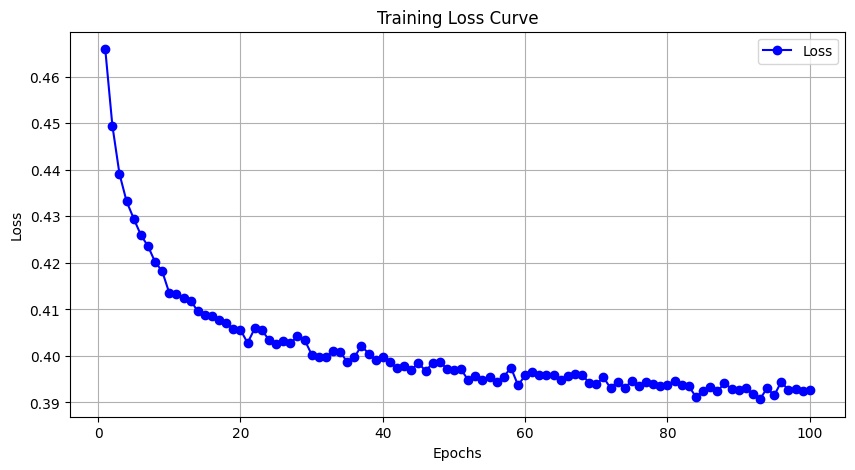

In [1]:
plot_loss_curve(epochs, loss_values)

### Model Evaluation

In [186]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        
        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 86.24%


### Performance Visualization

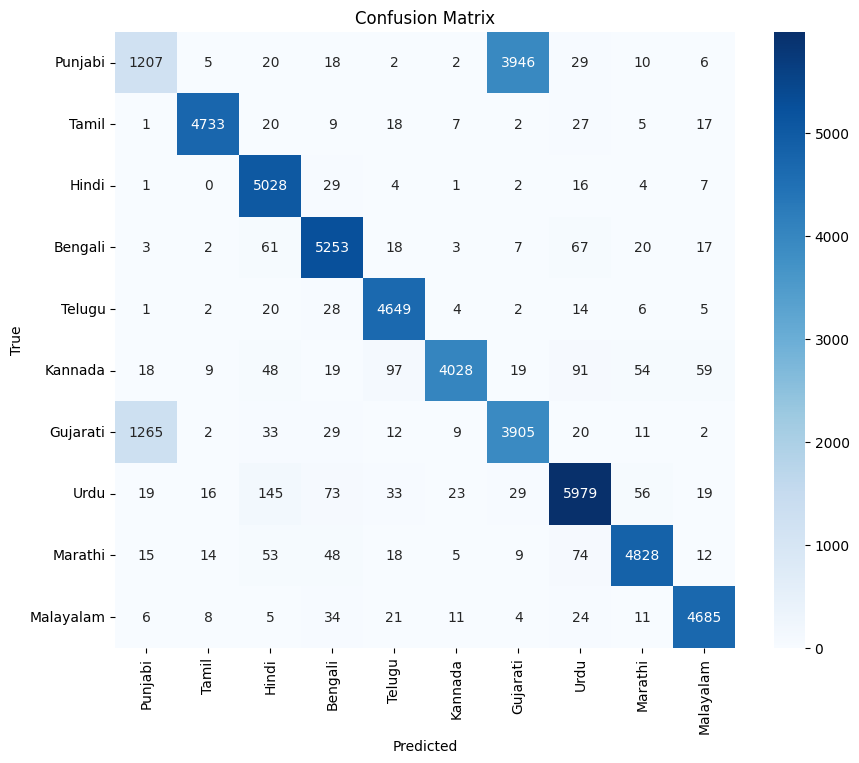

In [188]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        
        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=languages, yticklabels=languages)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [191]:
report = classification_report(all_labels, all_preds, target_names=languages)
print(report)

              precision    recall  f1-score   support

     Punjabi       0.48      0.23      0.31      5245
       Tamil       0.99      0.98      0.98      4839
       Hindi       0.93      0.99      0.96      5092
     Bengali       0.95      0.96      0.96      5451
      Telugu       0.95      0.98      0.97      4731
     Kannada       0.98      0.91      0.94      4442
    Gujarati       0.49      0.74      0.59      5288
        Urdu       0.94      0.94      0.94      6392
     Marathi       0.96      0.95      0.96      5076
   Malayalam       0.97      0.97      0.97      4809

    accuracy                           0.86     51365
   macro avg       0.86      0.86      0.86     51365
weighted avg       0.86      0.86      0.85     51365

